## Echoview Sv CSV Data Loading and Cleaning

This script aims to import Echoview Sv CSV datasets and add column names onto all the sample data, then export to a new CSV which can properly be used in PowerQuery and Pandas. Although this increases the file size by a little, it indeed facilitates the workflow when we load the dataset into a Pandas DataFrame.

Regions in an echogram that are highlighted as bad data are exported as values -9.900000000000001e+37. At the moment, this script changes those values to 0.0 to make the data cleaning and loading preperation smoother.

In [152]:
import pandas as pd
import numpy as np

# Filepath to Sv CSV
file_path = 'B175N_SV_CSV.CSV'

# Define the names of the fixed columns Echoview creates when exporting to CSV
fixed_column_names = [
    'Ping_index', 'Distance_gps', 'Distance_vl', 'Ping_date',
    'Ping_time', 'Ping_milliseconds', 'Latitude', 'Longitude', 
    'Depth_start', 'Depth_stop', 'Range_start', 'Range_stop', 'Sample_count'
]

# Read only the first row of the CSV to get Sample_count value
initial_data = pd.read_csv(file_path, usecols=fixed_column_names, nrows=1)
num_samples = int(initial_data['Sample_count'].iloc[0])

# Print the number of samples from Sample_count
print(f"Number of sample columns: {num_samples}\n")

# Generate sample column names based on the determined sample count
sample_column_names = ['Sample_' + str(i) for i in range(1, num_samples + 1)]

# Combine the fixed and sample column names for full DataFrame reading
column_names = fixed_column_names + sample_column_names

# Read the full CSV with the correct number of columns
echogram = pd.read_csv(file_path, names=column_names, header=0)  # Adjust header accordingly

# Get placeholder value
#placeholder_val = dsl_data['Sample_4268'].iloc[0]
placeholder_val = -9.900000000000001e+37
print("Placeholder value is: ", placeholder_val, end = "\n\n")

# Replace placeholder_val of -9.900000000000001e+37 with 0.0 (NaN causes errors when importing back to Echoview)
echogram.replace(placeholder_val, 0.0, inplace=True)

# Show a snippet of the data
print("Replaced all values containing -9.900000000000001e+37 to 0.0")

Number of sample columns: 14770

Placeholder value is:  -9.900000000000001e+37

Replaced all values containing -9.900000000000001e+37 to 0.0


## Data checking

After formatting our Pandas DataFrame to include headers for samples based off sample count and converting placeholder value from bad data regions to 0.0, we can run the following the verify the data.

In [153]:
# Show a snippet of the data
#print(dsl_data.head(17688))

# Testing to see if it reads the numerical data that starts around row 104 and onwards
print("Checking values transition from NaN to recorded values:\n")
print(echogram.iloc[0, 4260:4270])

# When comparing with Excel, Column value has an offset of +2, rows have an offset of +13
print("\nCross Referencing values\n")
print(echogram.iloc[574, 4271:4281])

# Print data types and column info
print("\nShow datatypes of columns:\n")
print(echogram.dtypes)
print("\nShow name and info of columns:\n")
print(echogram.columns)
print("\nShow first 5 rows:\n")
print(echogram.head())
num_rows = len(echogram)
print("\nShow number of all rows: ", num_rows)

Checking values transition from NaN to recorded values:

Sample_4248    -90.32006
Sample_4249   -90.277266
Sample_4250   -86.334991
Sample_4251   -81.809213
Sample_4252   -78.890503
Sample_4253    -77.21279
Sample_4254   -76.307577
Sample_4255   -75.744108
Sample_4256   -75.428342
Sample_4257   -75.491267
Name: 0, dtype: object

Cross Referencing values

Sample_4259   -80.595996
Sample_4260   -81.285096
Sample_4261   -81.920155
Sample_4262   -82.126371
Sample_4263   -81.969834
Sample_4264   -82.023456
Sample_4265   -82.940735
Sample_4266   -85.504776
Sample_4267   -90.792195
Sample_4268   -96.859219
Name: 574, dtype: object

Show datatypes of columns:

Ping_index        int64
Distance_gps    float64
Distance_vl     float64
Ping_date        object
Ping_time        object
                 ...   
Sample_14766    float64
Sample_14767    float64
Sample_14768    float64
Sample_14769    float64
Sample_14770    float64
Length: 14783, dtype: object

Show name and info of columns:

Index(['Ping_

In [154]:
# Select the subset of the DataFrame starting from column 14 to the last column
subset_df = echogram.iloc[:, 13:]

# Count the total number of 0.0 values in the subset
total_zero_subset = (subset_df == 0.0).sum().sum()
print(f"\nTotal number of 0.0 values in the subset: {total_zero_subset}")

# Count the total number of actual (non-0.0) values in the subset
total_values_subset = subset_df.size  # Total number of elements in the subset
total_non_zero_subset = total_values_subset - total_zero_subset
print(f"Total number of actual (non-0.0) values in the subset: {total_non_zero_subset}")

# Calculate the percentage of 0.0 and non-0.0 values in the subset
percentage_zero_subset = (total_zero_subset / total_values_subset) * 100
percentage_non_zero_subset = (total_non_zero_subset / total_values_subset) * 100
print(f"Percentage of 0.0 values in the subset: {percentage_zero_subset:.2f}%")
print(f"Percentage of actual (non-0.0) values in the subset: {percentage_non_zero_subset:.2f}%")


Total number of 0.0 values in the subset: 19427736
Total number of actual (non-0.0) values in the subset: 39164854
Percentage of 0.0 values in the subset: 33.16%
Percentage of actual (non-0.0) values in the subset: 66.84%


## Converting our sample data to a Numpy array

We get all the values of our sample columns from Sample_1 all the way to the final sample based on our sample_count value and made sure to associate them to their proper ping index. It essentially attempts to emulate the Echoview Code operator's way of structuring the array.

Note that we made a 2D array to make it easier for us to work with the data on here, but ideally single-beam data should remain 1D to be more in line with the Echoview Code operator if we plan to port this back on over.

In [155]:
# Get columns that start with 'Sample_' and exclude 'Sample_count'
sample_columns = [col for col in echogram.columns if col.startswith('Sample_') and col != 'Sample_count']

# Filter the DataFrame to only include these columns
sample_data = echogram[sample_columns]

# Checking the data with our new filtered DataFrame
print(sample_data.head())
print(sample_data.shape) 

# Convert the filtered DataFrame to a NumPy array to be used as an image matrix in OpenCV
image_data = sample_data.to_numpy(dtype='float32').T

   Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  Sample_7  \
0 -9.723568 -4.093496 -0.255926  2.181065  3.514151  4.178181  4.380940   
1 -9.744393 -4.094239 -0.255604  2.179737  3.532342  4.172628  4.382371   
2 -9.749479 -4.095331 -0.256092  2.169895  3.532342  4.173211  4.382371   
3 -9.722528 -4.087571 -0.259673  2.182449  3.540013  4.174344  4.373903   
4 -9.723568 -4.094491 -0.255926  2.181065  3.514151  4.178181  4.380940   

   Sample_8  Sample_9  Sample_10  ...  Sample_14761  Sample_14762  \
0  4.420597  4.395906   4.374333  ...           0.0           0.0   
1  4.411266  4.395291   4.382454  ...           0.0           0.0   
2  4.410415  4.395808   4.382454  ...           0.0           0.0   
3  4.427220  4.399365   4.379454  ...           0.0           0.0   
4  4.430097  4.397072   4.374333  ...           0.0           0.0   

   Sample_14763  Sample_14764  Sample_14765  Sample_14766  Sample_14767  \
0           0.0           0.0           0.0           0.0  

## Calculate the depth per sample

This metric tells you how much vertical space each pixel (or row of pixels) in your image represents, which is essential for making physical interpretations from the image.

In [156]:
Depth_start = 2.43246484  # Example start depth in meters
Depth_stop = 2004.039531  # Example stop depth in meters
Sample_count = 14819  # Example number of samples

depth_per_sample = (Depth_stop - Depth_start) / Sample_count

rounded_depth= round(depth_per_sample, 3)
print(rounded_depth, "meters per sample")

0.135 meters per sample


## Verifying our echogram

We now try to replicate the way we view our echogram on Echoview by following the Viridis color scheme and inserting the display minimum + display range values we have on Echoview onto Matplotlib.

Areas highlighted yellow are the bad region areas set on Echoview where the values on the Sv CSV were set to. -9.9E+37. These were replaced earilier to 0.0 dB instead.

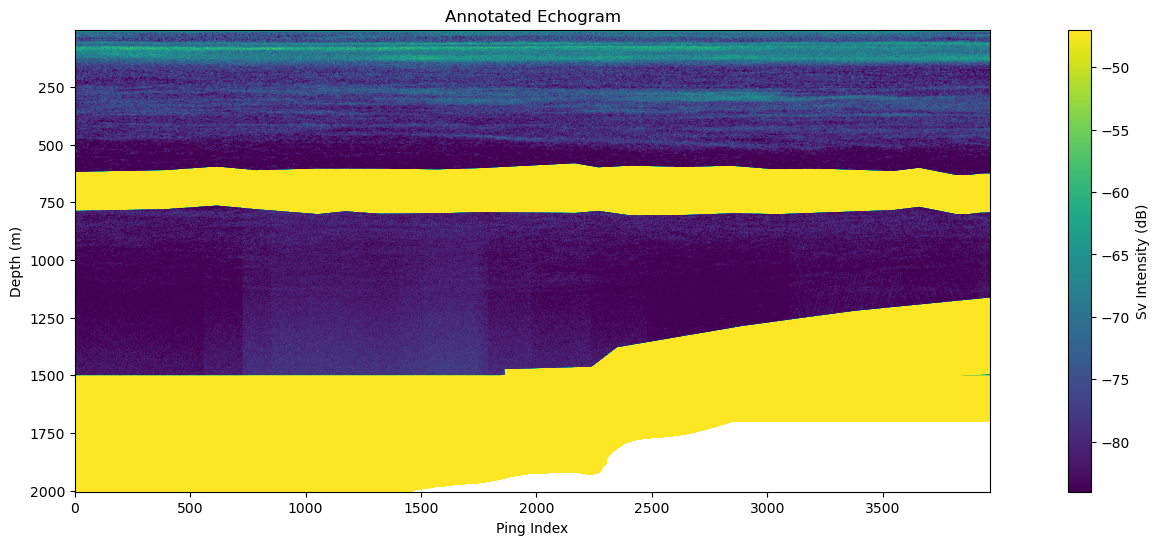

In [157]:
import cv2
import matplotlib.pyplot as plt

# Define the display settings
vmin = -84  # Display minimum intensity
vmax = vmin + 37  # Display maximum intensity, derived from Display range

# Load the image data
plt.figure(figsize=(20, 6))
plt.imshow(image_data, cmap='viridis', extent=[0, image_data.shape[1], Depth_stop, Depth_start], vmin=vmin, vmax=vmax)
plt.colorbar(label='Sv Intensity (dB)')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.title('Annotated Echogram')
plt.show()

## Filtering intensity values and adjusting target depth

We filter the intensity values to give us a clearer picture of the DSL we are working with based on a certain depth range they're found in.

The first three variables are essential as it tells our program where we should focus on depending on the depth in meters and we can filter this data based on the intensity level of the DSL before we scale it.

Note: to be able to highlight the layer(s), we can adjust the min_val and max_val which helps with visbility

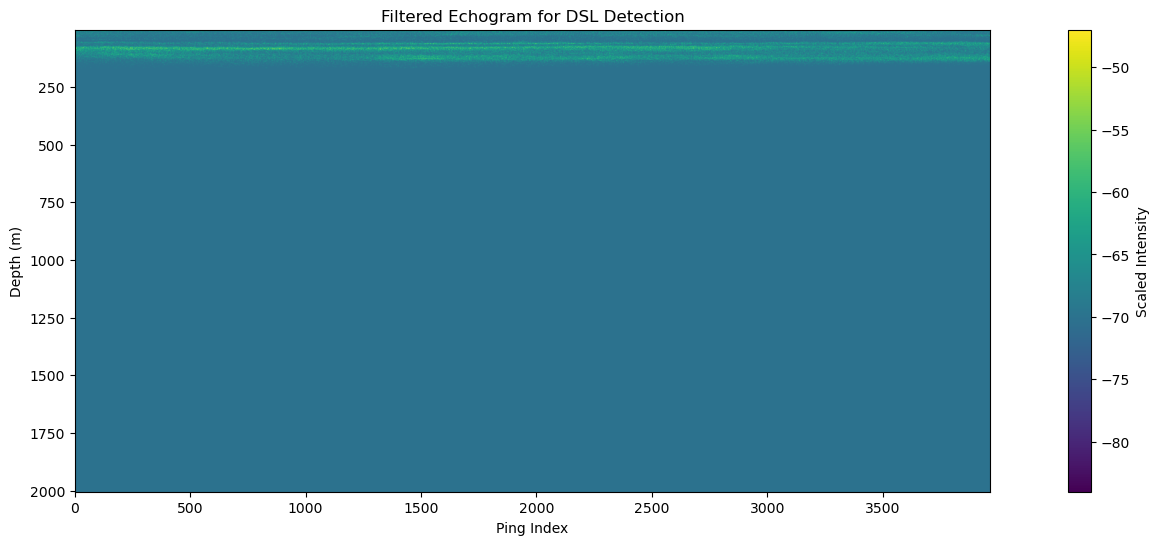

In [158]:
# Assign our threshold dB values where DSLs are present
min_val, max_val = -70, -50

# Adjust the depth in meters where the DSL are present
dsl_depth_range = [5, 165]

# Calculate depth array
depths = np.arange(image_data.shape[0]) * depth_per_sample

# Mask for depth range
depth_mask = (depths >= dsl_depth_range[0]) & (depths <= dsl_depth_range[1])

# Apply depth mask to each row (assuming image_data.shape[0] is the depth dimension)
filtered_data = np.where(depth_mask[:, np.newaxis], image_data, min_val)

# Intensity filter
filtered_data = np.clip(filtered_data, min_val, max_val)

# Display
plt.figure(figsize=(20, 6))
plt.imshow(filtered_data, cmap='viridis', extent=[0, image_data.shape[1], Depth_stop, Depth_start], vmin=vmin, vmax=vmax)
plt.colorbar(label='Scaled Intensity')
plt.title('Filtered Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

## Dynamic filtering using percentiles

This version of the filtering above uses a percentile based filtering to reduce noise. giving it a shorter range with the percentile should help focus on the main signal.

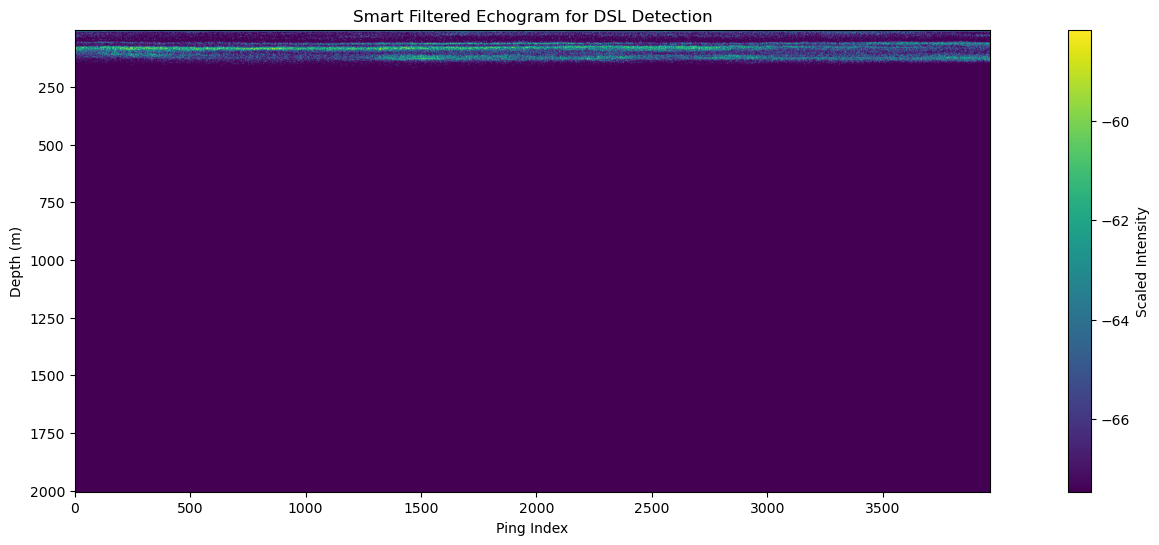

In [159]:
# Assign our threshold dB values where DSLs are present
min_val, max_val = -80, -50

# Adjust the depth in meters where the DSL are present
dsl_depth_range = [0, 165]

# Define the percentile values for dynamic thresholding
lower_percentile, upper_percentile = 60, 95

# Calculate depth array and apply masking for depth range
depths = np.arange(image_data.shape[0]) * depth_per_sample
depth_mask = (depths >= dsl_depth_range[0]) & (depths <= dsl_depth_range[1])

# Apply depth mask
depth_filtered_data = image_data[depth_mask]

# Determine dynamic intensity thresholds based on percentiles
min_val = np.percentile(depth_filtered_data, lower_percentile)
max_val = np.percentile(depth_filtered_data, upper_percentile)

# Apply intensity filter
filtered_data = np.clip(image_data, min_val, max_val)

# Apply the depth mask with new intensity values
final_filtered_data = np.where(depth_mask[:, np.newaxis], filtered_data, min_val)

# Display the filtered echogram
plt.figure(figsize=(20, 6))
plt.imshow(final_filtered_data, cmap='viridis', extent=[0, image_data.shape[1], Depth_stop, Depth_start], vmin=min_val, vmax=max_val)
plt.colorbar(label='Scaled Intensity')
plt.title('Smart Filtered Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

## Scale the data

Scale our data to 0 - 255 to work correctly with our image processing techniques that require an 8-bit image.

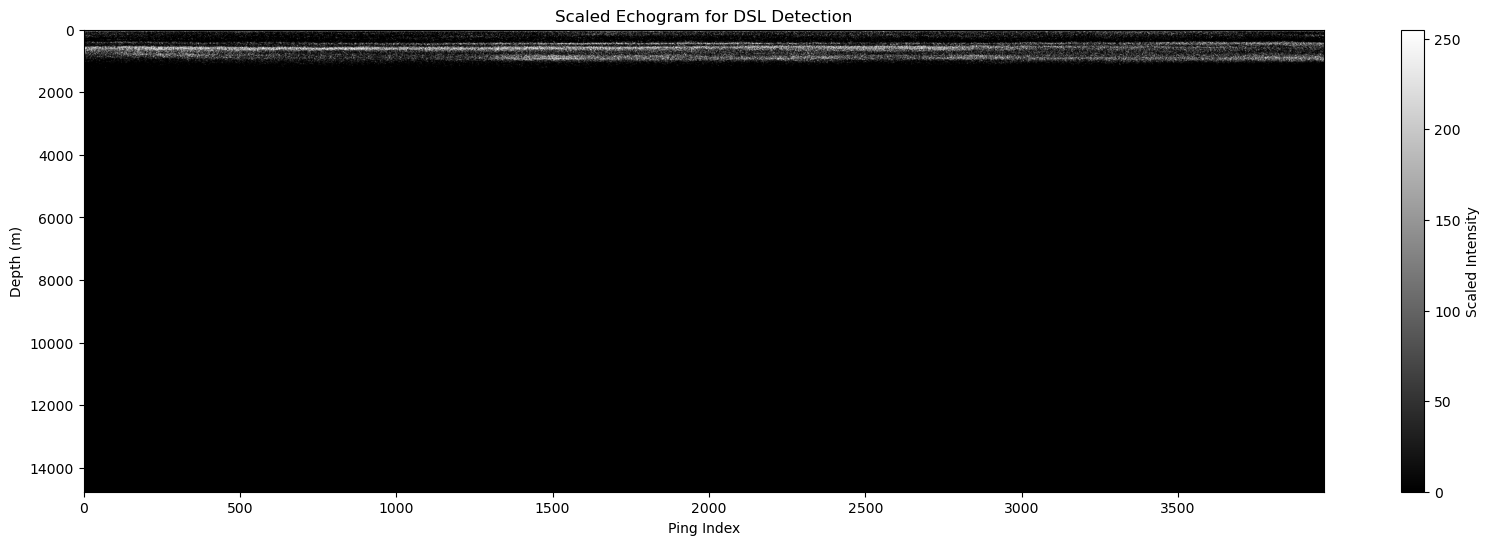

In [160]:
# Scale to 0-255
scaled_data = np.clip((final_filtered_data - min_val) / (max_val - min_val) * 255, 0, 255).astype(np.uint8)

# Display
plt.figure(figsize=(20, 6))
plt.imshow(scaled_data, cmap='gray', aspect='auto')
plt.colorbar(label='Scaled Intensity')
plt.title('Scaled Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

## Gaussian blur

Apply a gaussian blur to our image.

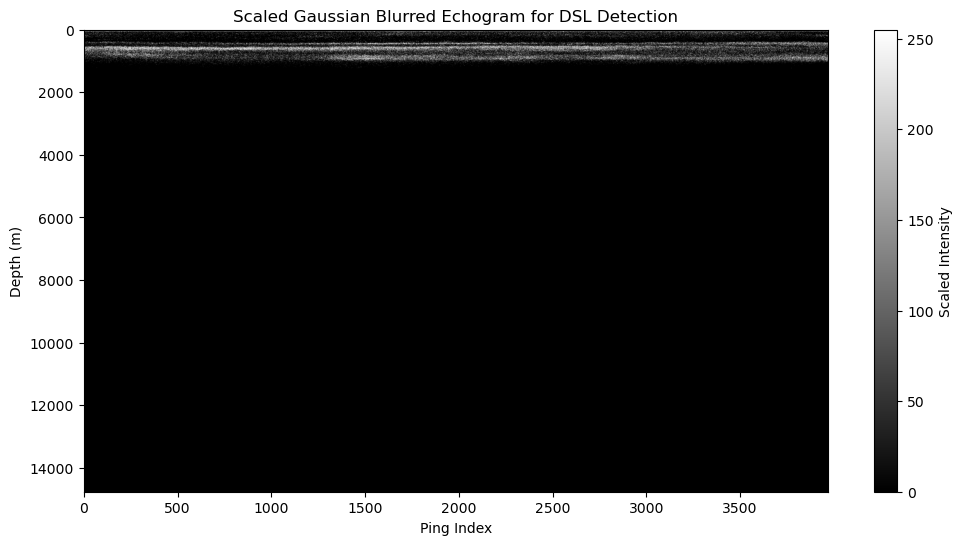

In [161]:
# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(scaled_data, (3, 9), 0)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(blurred_image, cmap='gray', aspect='auto')
plt.colorbar(label='Scaled Intensity')
plt.title('Scaled Gaussian Blurred Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

## Apply Canny edge detection

Applies canny edge detection to our Gaussian blurred image.

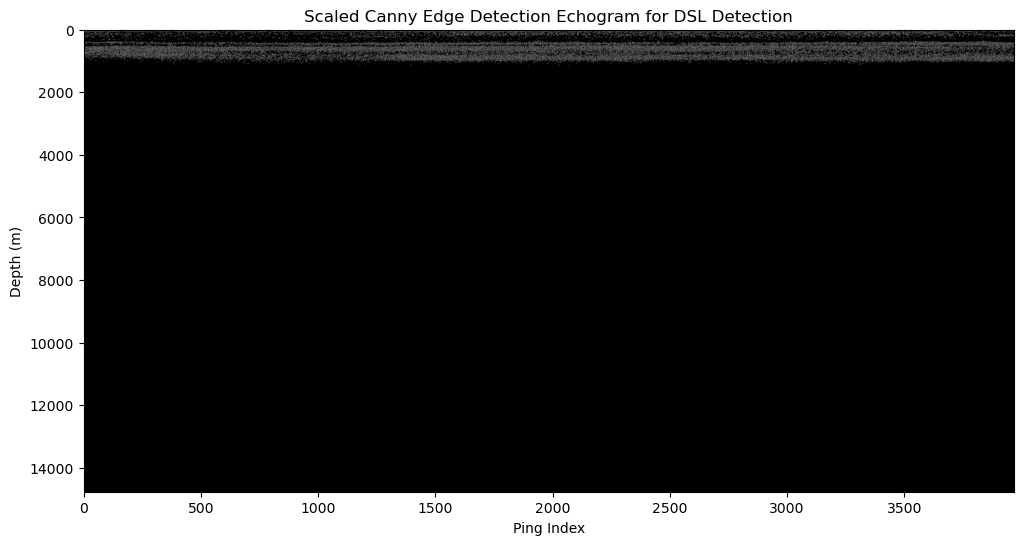

In [162]:
# Apply Canny Edge Detection
edges = cv2.Canny(blurred_image, 225, 275)  # Adjust thresholds as needed for your specific data (150 160 works better without dyn_thresh_filtering)

# Displaying the Canny edges
plt.figure(figsize=(12, 6))
plt.imshow(edges, cmap='gray', aspect = 'auto')
plt.title('Scaled Canny Edge Detection Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

## Apply contours

Find contours from our canny edge image.

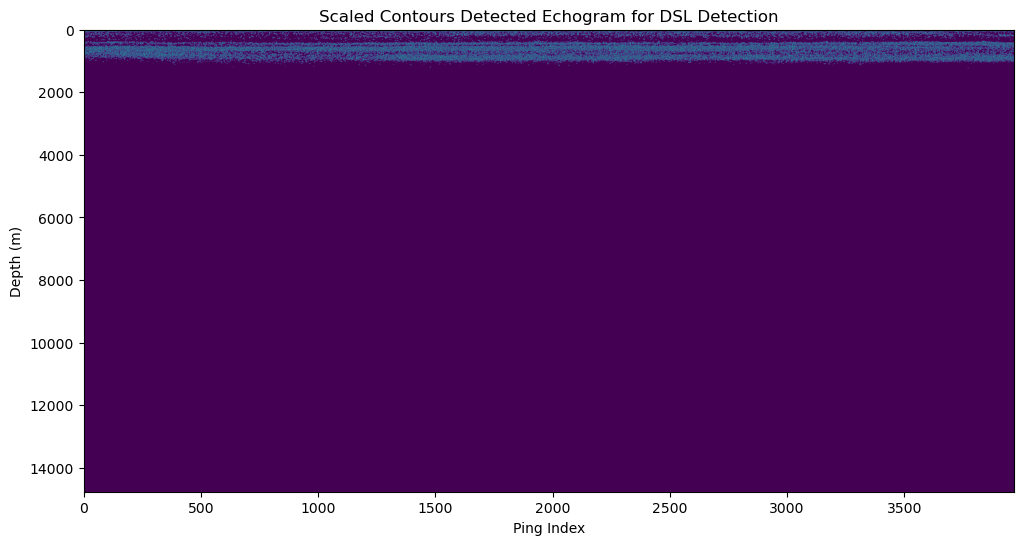

In [163]:
# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an image to draw the contours on
contour_image = np.zeros_like(edges)

# Draw the contours
cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)

# Displaying the contours
plt.figure(figsize=(12, 6))

plt.imshow(contour_image, aspect = 'auto')
plt.title('Scaled Contours Detected Echogram for DSL Detection')
plt.xlabel('Ping Index')
plt.ylabel('Depth (m)')
plt.show()

#cv2.imshow("Contours detected", contour_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# Export to CSV

Export a cleaned version of our dataset based on the changes made in the script

In [164]:
# Create a CSV export of the data with Sample_1 to Sample_n as headers for each header
#dsl_data.to_csv('cleaned_B175D_Sv_CSV.csv')

# Export the CSV without the sample column names in headers
# Create a dictionary where key is the original column name, and value is the new column name without 'Sample_' prefix
# Retain 'Sample_count' but empty headers for 'Sample_1' to 'Sample_n'
#export_columns = {name: "" if 'Sample_' in name and not name == 'Sample_count' else name for name in dsl_data.columns}

# Use the dictionary to rename columns temporarily just for exporting
#export_data = dsl_data.rename(columns=export_columns)
#export_data.to_csv('cleaned_B175D_Sv_CSV.csv', index=False, header=True)